In [2]:
# magics: ensures that any changes to the modules loaded below will be re-loaded automatically
%load_ext autoreload
%autoreload 2

import os 
import sys
sys.path.append(os.path.abspath(''))
import numpy as np
import plotly.graph_objects as go

In [3]:
from functions import plotgenerator as pg
import utils, model, egm, simulations, estimation 

# Solution to the model

In [4]:
# Setup
par_init_sol = model.gp_model()

### plotting Income shifter

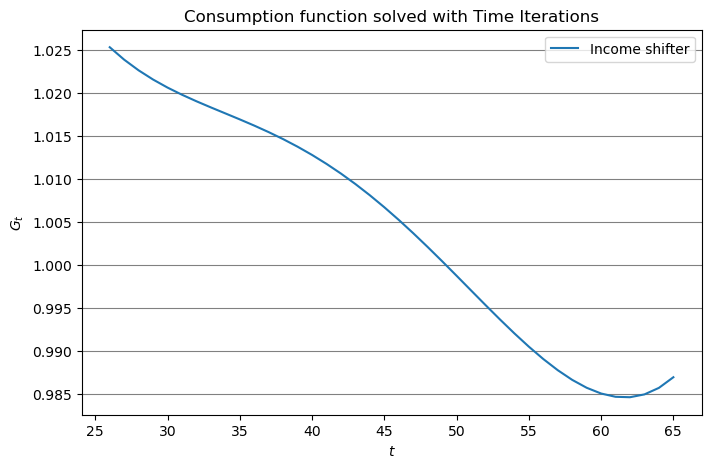

In [5]:
# Print consumption function
fig = pg.PlotFigure(figsize=(8,5),fontname='Arial')
fig.add_plot(range(par_init_sol.par.t0,par_init_sol.par.Tr+1),par_init_sol.par.G, label=f"Income shifter", linestyle='-')
fig.set_ylabel(f"$G_t$")
fig.set_xlabel(f"$t$")
fig.set_title(f'Consumption function solved with Time Iterations')
fig.add_gridlines(axis='y')
fig.add_legend()
fig.show()

### solving the model

In [6]:
# Solve the model
sol = egm.solve(par_init_sol.par)

### plotting the results

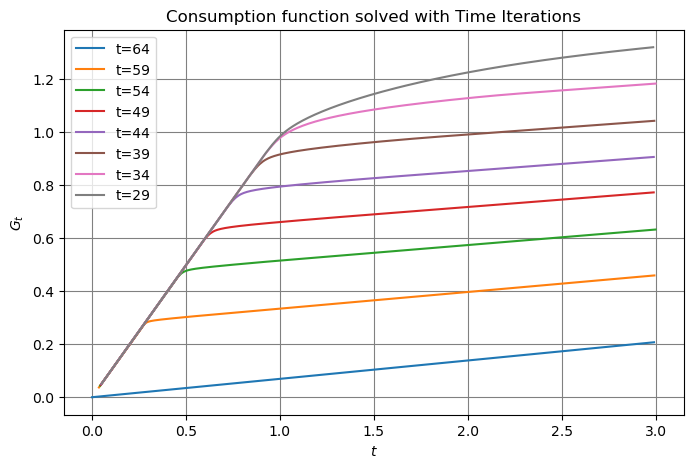

In [7]:
# Print consumption function
fig = pg.PlotFigure(figsize=(8,5),fontname='Arial')
for t in range(par_init_sol.par.Tr_N-1,par_init_sol.par.t0_N,-5):
    criteria = np.where(sol.m[:,t] <= 3, True, False)
    fig.add_plot(sol.m[criteria,t],sol.c[criteria,t], label=f"t={25+t}", linestyle='-')
fig.set_ylabel(f"$G_t$")
fig.set_xlabel(f"$t$")
fig.set_title(f'Consumption function solved with Time Iterations')
fig.add_gridlines(axis='both')
fig.add_legend()
fig.show()

### simulate how results look like

In [8]:
sim = simulations.sim_setup(par_init_sol.par)
simulations.draw_random(par_init_sol.par, sim)
sim = simulations.simulate(sim, par_init_sol.par, sol)

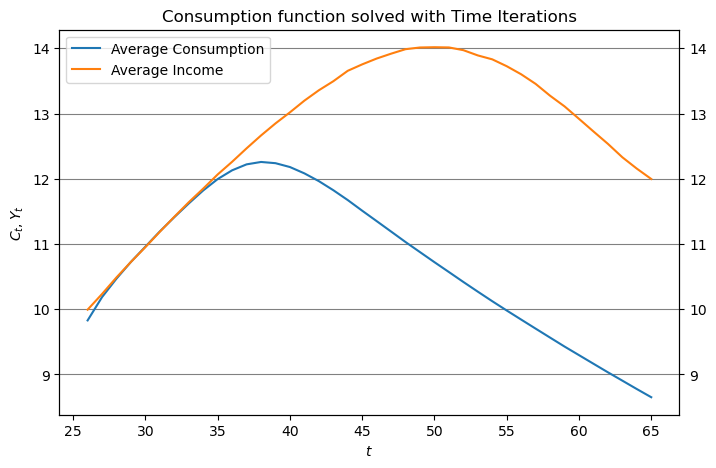

In [9]:
# Print consumption function
fig = pg.PlotFigure(figsize=(8,5),fontname='Arial')
x = range(par_init_sol.par.t0,par_init_sol.par.Tr+1)
fig.add_plot(x,sim.C_avg, label=f"Average Consumption", linestyle='-',axis='y1')
fig.add_plot(x,sim.Y_avg, label=f"Average Income", linestyle='-',axis='y1')
fig._set_scaling()
fig.set_ylabel(f"$C_t, Y_t$")
fig.set_xlabel(f"$t$")
fig.set_title(f'Consumption function solved with Time Iterations')
fig.add_gridlines(axis='y')
fig.add_legend()
fig.show()

# Estimation based on random data

### Data generation

In [19]:
# Setup params
par_dgp = model.gp_model().par
par_dgp.beta = 0.95
par_dgp.rho = 0.45
sol_dgp = egm.solve(par_dgp)

dgp_par = [par_dgp.beta, par_dgp.rho]
# 
sim_dgp = simulations.sim_setup(par_dgp)
simulations.draw_random(par_dgp, sim_dgp)
sim_dgp = simulations.simulate(sim_dgp, par_dgp, sol_dgp)

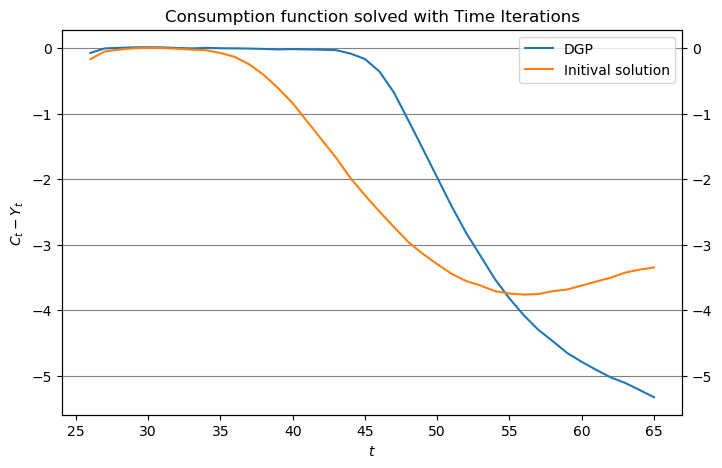

In [20]:
# Print consumption function
fig = pg.PlotFigure(figsize=(8,5),fontname='Arial')
x = range(par_init_sol.par.t0,par_init_sol.par.Tr+1)
y1 = sim_dgp.C_avg - sim_dgp.Y_avg
y2 = sim.C_avg - sim.Y_avg
fig.add_plot(x,y1, label=f"DGP", linestyle='-',axis='y1')
fig.add_plot(x,y2, label=f"Initival solution", linestyle='-',axis='y1')
fig._set_scaling()
fig.set_ylabel(f"$C_t - Y_t$")
fig.set_xlabel(f"$t$")
fig.set_title(f'Consumption function solved with Time Iterations')
fig.add_gridlines(axis='y')
fig.add_legend()
fig.show()

In [21]:
weight_mat_inv = np.eye(sim_dgp.C_avg.size)   # The identity matrix and I^-1=I
est = estimation.SMD(model=par_dgp,solver=egm.solve, simulator=simulations, mom_data=sim_dgp.C_avg)

### grid search

In [35]:
est.beta_grid = np.arange(0.9,0.95,0.01)
est.rho_grid = np.arange(0.9,0.95,0.01)
est.estimate(theta0=[0.9,0.4],est_par=['beta','rho'],W=weight_mat_inv, grid=True)

### estimation

In [22]:
est.beta_grid = np.arange(0.9,0.95,0.01)
est.rho_grid = np.arange(0.9,0.95,0.01)
est.estimate(theta0=[0.9,0.4],est_par=['beta','rho'],W=weight_mat_inv, grid=False)

In [32]:
print(f'estimated values using grid method {est.est} and true parameters {dgp_par}')

estimated values using grid method [0.95000092 0.44997579] and true parameters [0.95, 0.45]


In [33]:
# Obtain the variance-covariance matrix
var_cov_matrix = est.estimate_variance_covariance_matrix(est.est, ['beta','rho'], W=weight_mat_inv)
print(var_cov_matrix)

[[-2.82257901e+18  8.16371622e+19]
 [ 8.16371622e+19 -2.36118324e+21]]


### plot the objective function for different values

In [37]:
# Sample data
x, y = np.meshgrid(np.arange(0.9,1,0.01), np.arange(0.9,1,0.01))
z = est.grid

# Create the surface plot
fig = go.Figure(data=[go.Surface(z=z, x=x, y=y)])

# Update layout
fig.update_layout(title='Objective function', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90),
                scene=dict(xaxis=dict(title='beta'),
                    yaxis=dict(title='rho')))

# Show the figure
fig.show()

# Estimation using data from BLS

In [47]:
cat = ['Under 25 years', '25-34 years', '35-44 years', '45-54 years', '55-64 years', '65 years and older']
data = [46359, 67883, 86049, 91074, 78079, 57818]
for i in range(6):
    print(f"{cat[i]}: {data[i]:,.1f}")


Under 25 years: 46,359.0
25-34 years: 67,883.0
35-44 years: 86,049.0
45-54 years: 91,074.0
55-64 years: 78,079.0
65 years and older: 57,818.0


In [52]:
# Setup
par_real = model.gp_model().par
# solve model
sol_real = egm.solve(par_real)

real_par = [par_real.beta, par_real.rho]
# 
sim_real = simulations.sim_setup(par_real)
simulations.draw_random(par_real, sim_real)
sim_real = simulations.simulate(sim_real, par_real, sol_real)

In [53]:
est.sim.C_avg
for i in range(0,len(est.sim.C_avg),10):
    print(f'{i+25}-{i+25+10}', est.sim.C_avg[i:i+10].mean())

25-35 11.015796537370472
35-45 12.89351313674968
45-55 11.287235559882191
55-65 8.37258987105474


In [54]:
real_data = np.array([67883, 86049, 91074, 78079])
real_data = np.log(real_data)
print(real_data)

[11.12554091 11.36267218 11.41942764 11.26547641]


In [55]:
weight_mat_inv = np.eye(real_data.size)   # The identity matrix and I^-1=I
est_real = estimation.SMD(model=par_real,solver=egm.solve, simulator=simulations, mom_data=real_data)
est_grid = estimation.SMD(model=par_real,solver=egm.solve, simulator=simulations, mom_data=real_data)

In [57]:
est_real.estimate(theta0=[0.9,0.4],est_par=['beta','rho'],W=weight_mat_inv)

In [ ]:
print(est_real.est_out.success)
print(f'estimated values {est_real.est}')

In [ ]:
if hasattr(est,'grid'):
  from plotly.subplots import make_subplots

  fig = make_subplots(
      rows=1, 
      cols=2,
      start_cell="top-left", 
      specs=[
          [{"type": "surface"}, {"type": "scattergl"}], 
      ]
  )
  fig.update_layout(paper_bgcolor="rgba(0,0,0,0)",plot_bgcolor="grey",font=dict(family="Arial",size=12,color="white"))
  # Sample data
  x, y = np.meshgrid(est.beta_grid, est.rho_grid)
  z = est.grid

  # Create the surface plot
  # fig = go.Figure(data=[go.Surface(z=z, x=x, y=y)])
  fig.add_trace(go.Surface(z=z, x=x, y=y, coloraxis=dict(coloraxis=1),
                           ),row=1,col=1)

  # Update axes titles for the mesh plot
  fig.update_scenes(
      xaxis_title='Beta',
      yaxis_title='Rho',
      zaxis_title='Objective function',
      row=1, col=1
  )
  fig.update_scenes(aspectratio=dict(x=1, y=1, z=0.7),
                     row=1, col=1)

  fig.update_layout(title='Objective function', autosize=False,width=1000, height=500,margin=dict(l=65, r=50, b=65, t=90))
  # set the background color
  y = est.grid[4,:]
  x = est.rho_grid

  # fig = go.Figure()
  fig.add_trace(go.Scatter(x=x, y=y, mode='lines', ),row=1,col=2)
  # Update axes titles for each subplot
  fig.update_xaxes(title_text=f'rho', row=1, col=2)
  fig.update_yaxes(title_text='Objective function', row=1, col=2)

  fig.show()
else:
  print('No grid found')

# Extension
Imagine two types of households with different timepreference, $\beta$

#### Type I

In [99]:
# Setup params
par_type1 = model.gp_model().par
par_type1.beta = 0.99
sol_type1 = egm.solve(par_type1)

type1_par = [par_type1.beta, par_type1.rho]
# 
sim_type1 = simulations.sim_setup(par_type1)
simulations.draw_random(par_type1, sim_type1)
sim_type1 = simulations.simulate(sim_type1, par_type1, sol_type1)

#### Type II

In [100]:
# Setup params
par_type2 = model.gp_model().par
par_type2.beta = 0.90
sol_type2 = egm.solve(par_type2)

type2_par = [par_type2.beta, par_type2.rho]
# 
sim_type2 = simulations.sim_setup(par_type2)
simulations.draw_random(par_type2, sim_type2)
sim_type2 = simulations.simulate(sim_type2, par_type2, sol_type2)

#### Aggregate consumption
Denoting the share of type I households as $\lambda$, the aggregate consumption is given by:
$$
C^{agg}_t = \lambda C^I_t + (1-\lambda) C^{II}_t
$$

In [105]:
lambda1 = 0.4
lambda2 = 1 - lambda1
agg_model = model.gp_model().par
agg_cons = lambda1*sim_type1.C_avg + lambda2 * sim_type2.C_avg

[ 3.74485398  3.91954913  4.10286272  4.29484731  4.49404988  4.70432658
  4.92291878  5.15334622  5.39554139  5.64639227  5.90918627  6.18337883
  6.47126878  6.77282432  7.09058915  7.42110762  7.76789256  8.13029475
  8.50939985  8.90478874  9.32101962  9.75538632 10.20848009 10.68503118
 11.1827957  11.70409488 12.24779749 12.81771126 13.41344577 14.03863582
 14.69329996 15.37848711 16.09383596 16.84114965 17.62643679 18.44670325
 19.30306413 20.20027209 21.13646987 22.11657626  9.97177252 10.24632657
 10.49929177 10.74335077 10.96984767 11.20325112 11.42137349 11.63774304
 11.85584423 12.0660992  12.25721458 12.46527229 12.65324032 12.82835142
 13.00553221 13.18453024 13.33935381 13.47802482 13.62443658 13.71795147
 13.80792297 13.8781611  13.94207359 13.96681697 13.96845708 13.96295596
 13.91278906 13.84071478 13.7641481  13.65092708 13.423374   12.45409534
 10.9865925   9.58986649  8.34486676  7.25684508  6.30960029  5.48794374
  4.77033153  4.14829759  7.4810051   7.71561559  7

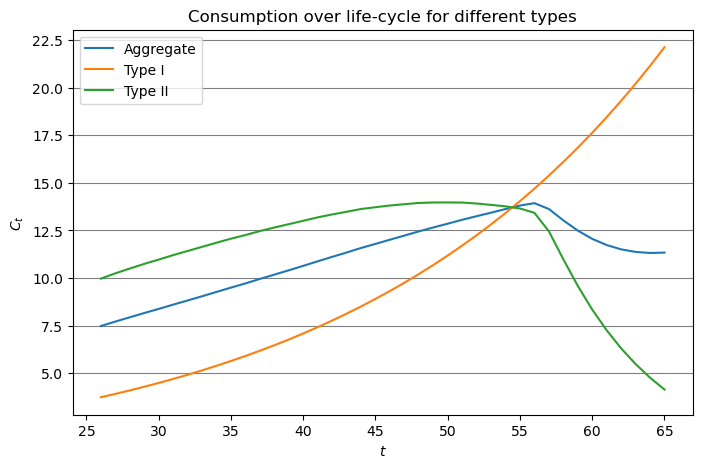

In [102]:
# plot consumption
fig = pg.PlotFigure(figsize=(8,5),fontname='Arial')
x = range(par_init_sol.par.t0,par_init_sol.par.Tr+1)
fig.add_plot(x,agg_cons, label=f"Aggregate", linestyle='-',axis='y1')
fig.add_plot(x,sim_type1.C_avg, label=f"Type I", linestyle='-',axis='y1')
fig.add_plot(x,sim_type2.C_avg, label=f"Type II", linestyle='-',axis='y1')
fig.add_gridlines(axis='y')
fig.set_ylabel(f"$C_t$")
fig.set_xlabel(f"$t$")
fig.set_title(f'Consumption over life-cycle for different types')
fig.add_legend()
fig.show()


In [87]:
weight_mat_inv = np.eye(agg_cons.shape[0])   # The identity matrix and I^-1=I
est_ext = estimation.SMD(model=agg_model,solver=egm.solve, simulator=simulations, mom_data=agg_cons)

In [88]:
est_ext.beta_grid = np.arange(0.9,0.99,0.01)
est_ext.rho_grid = np.arange(0.4,0.5,0.01)
est_ext.estimate(theta0=[0.9,0.4],est_par=['beta','rho'],W=weight_mat_inv, grid=True)

In [89]:
# Sample data
x, y = np.meshgrid(np.arange(0.9,1,0.01), np.arange(0.9,1,0.01))
z = est_ext.grid

# Create the surface plot
fig = go.Figure(data=[go.Surface(z=z, x=x, y=y)])

# Update layout
fig.update_layout(title='Objective function', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90),
                scene=dict(xaxis=dict(title='beta'),
                    yaxis=dict(title='rho')))

# Show the figure
fig.show()
print(f'estimated values using grid method {est_ext.est} ')

estimated values using grid method [0.9700000000000001, 0.4] 


In [97]:
est_ext.estimate(theta0=[0.97,0.4],est_par=['beta','rho'],W=weight_mat_inv, grid=False)

estimated values using grid method [1.033642   6.89999745]


In [98]:
if est_ext.est_out.success:
    print(f'estimated values using scipy optimizer {est_ext.est}')
else:
    print(f'optimization failed')

estimated values using scipy optimizer [1.033642   6.89999745]
